# Comparing anomaly detection algorithms for outlier detection on 3D toy datasets
---

## Brief overview

This example is an extension of an anomaly detection comparison on 2D toy datasets from [``sckit-learn``](https://scikit-learn.org/stable/auto_examples/plot_anomaly_comparison.html#sphx-glr-auto-examples-plot-anomaly-comparison-py). These experiment applied four algorithms on five 3D toy datasets. Four algorithms are in sklearn, which are [``sklearn.covariance.EllipticEnvelope``](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html#sklearn.covariance.EllipticEnvelope), [`sklearn.svm.OneClassSVM`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html#sklearn.svm.OneClassSVM), [`sklearn.ensemble.IsolationForest`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest), and [`sklearn.neighbors.LocalOutlierFactor`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#sklearn.neighbors.LocalOutlierFactor). The outlier detecting performance is measured using accuracy from [`sklearn.metrics.accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score) and AUC score from [`sklearn.metrics.roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html).

## Import packages

In [1]:
# Graphing and calculation packages
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
import time
import matplotlib
from sklearn.datasets import make_moons, make_blobs

# Algorithm packages
from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# Performance measurement packages
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

## Data simulation 

Here are the dafault parameters of the data set, which user can adjust the values:

  * ``n_samples = 500`` - the number of sample
  * ``outlliers_fraction = 0.15`` - ratio of outliers to all sample. In this experiment, the outliers have uniform distribution. 
  * ``d_noise = 10`` - the number of Gaussian dimensional noise dimension.
      - 
Modern brain imaging techniques apply functional data analysis (FDA), which views curves and hypersurfaces infinite-dimensional variables. However, most of variables do not contain information, and we refer them as ``noise dimensions``.
  * ``line_sd = 0.06`` - the standard deviation (sd) of the linear and helix datasets 
  * ``cluster_sd = 0.2`` - sd of two Gaussian mixture datasets 
  * ``noise_sd = 2`` - sd of each variable in dimensional noise 

  
Each dataset has three signal dimensions, which is followed figure 1 in the paper:
    
  * Madhyastha, Meghana, et al. "Geodesic Learning via Unsupervised Decision Forests." arXiv preprint arXiv:1907.02844 (2019).

There are five dataset:
  
  1. Linear
      - Each point $x$ is parameterized by $p = (0.4t, 0.6t, t)$, with $t \in (-1, 1)$ where $t$ is sampled from a grid with equal spacing. Each point has noise, std =$0.06$ in each axis.      
  2. Spiral helix
      - Each point $x$ is parameterized by $p = (t \cos(t), t\sin(t), t)$, with $t \in (2 \pi, 9 \pi)$ on an equally spaced grid. Each point has noise, std =$0.06$ in each axis.      
  3. Sphere shell
      - Each point $x$ is parameterized by $p = (r \cos(u) \sin(v), r \sin(u) \sin(v), r \cos(v))$, with $u \in (0, 2\pi), v \in (0, \pi)$ and $r = 9$ where $u, v$ are sampled form a grid with equal spacing. Here is a [link](https://stackoverflow.com/questions/9600801/evenly-distributing-n-points-on-a-sphere) for how to generate a sphere.     
  4. Three aligned gaussian mixture
      - Each point $x$ is drawn from a mixture of Gaussian distributions: $P = \sum_{j=1}^3 \mathcal{N}(\mu_j,\Sigma),$ with $ (\mu_1, \mu_2, \mu_3) = \left( \ \begin{bmatrix} -0.7 \\-0.7\\-0.7 \end{bmatrix},  \begin{bmatrix} 0 \\0\\0 \end{bmatrix} , \begin{bmatrix} -0.7 \\-0.7\\-0.7 \end{bmatrix} \ \right)$ and $\Sigma = \sigma^2 \mathbf{I} = (0.2)^2 \mathbf{I} \ \ $ when $\mathbf{I}$ is the identity matrix.
  5. Three misaligned gaussian mixture
      - Each point $x$ is drawn from a mixture of Gaussian distributions: $P = \sum_{j=1}^3 \mathcal{N}(\mu_j,\Sigma),$ with $ (\mu_1, \mu_2, \mu_3) = \left( \ \begin{bmatrix} -0.7 \\-0.7\\-0.7 \end{bmatrix},  \begin{bmatrix} 0.7 \\0.7\\-0.7 \end{bmatrix} , \begin{bmatrix} -0.7 \\0.7\\0.7 \end{bmatrix} \ \right)$ and $\Sigma = \sigma^2 \mathbf{I} = (0.2)^2 \mathbf{I} $.

In [2]:
# Data parameter
d_noise = 10  # number of Gaussian dimensional noise
n_samples = 500
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers
line_sd = 0.06  # sd of the line in dataset 1 and 2
cluster_sd = 0.2  # sd of the cluster in dataset 4 and 5
noise_sd = 2  # sd of the cluster in dimensional noise

# Define datasets
## 1: Linear
def linear(samples=1, sd=0.0):
    t_lin = np.transpose(np.linspace(-1, 1, samples))
    X_lin = np.c_[
        0.4 * t_lin + sd * np.random.randn(samples),
        0.6 * t_lin + sd * np.random.randn(samples),
        t_lin + sd * np.random.randn(samples),
    ]
    return X_lin


X_lin = linear(samples=n_inliers, sd=line_sd)

## 2: Helix
def helix(samples=1, sd=0.0):
    t_hex = np.transpose(np.linspace(2 * np.pi, 9 * np.pi, samples))
    xline = t_hex * np.cos(t_hex)  # before rescale
    xline = xline / (max(xline) - min(xline)) * 2 + sd * np.random.randn(samples)
    yline = t_hex * np.sin(t_hex)  # before rescale
    yline = yline / (max(yline) - min(yline)) * 2 + sd * np.random.randn(samples)
    zline = (t_hex - (max(t_hex) + min(t_hex)) / 2) / (
        max(t_hex) - min(t_hex)
    ) * 2 + sd * np.random.randn(samples)
    X_hex = np.c_[xline, yline, zline]
    return X_hex


X_hex = helix(samples=n_inliers, sd=line_sd)

## 3: Sphere, equally distribution
def fibonacci_sphere(samples=1, randomize=True):
    rnd = 1.0
    if randomize:
        rnd = np.random.random() * samples
    points = []
    offset = 2.0 / samples
    increment = np.pi * (3.0 - np.sqrt(5.0))
    for i in range(samples):
        y = ((i * offset) - 1) + (offset / 2)
        r = np.sqrt(1 - pow(y, 2))
        phi = ((i + rnd) % samples) * increment
        x = np.cos(phi) * r
        z = np.sin(phi) * r
        points.append([x, y, z])
    return points


X_sph = np.array(fibonacci_sphere(samples=n_inliers))

## 4: Gaussian Mixture
def gaussian_blobs(samples=3, sd=0.0):
    blobs_params = dict(random_state=0, n_samples=samples, n_features=3)
    X_gau = make_blobs(
        centers=[[-0.7, -0.7, -0.7], [0, 0, 0], [0.7, 0.7, 0.7]],
        cluster_std=[sd, sd, sd],
        **blobs_params
    )[0]
    return X_gau


X_gau = gaussian_blobs(samples=n_inliers, sd=cluster_sd)

## 5: Misaligned Gaussian Mixture
def misaligned_blobs(samples=3, sd=0.0):
    blobs_params = dict(random_state=0, n_samples=samples, n_features=3)
    X_misaligned = make_blobs(
        centers=[[-0.7, -0.7, -0.7], [0.7, 0.7, -0.7], [-0.7, 0.7, 0.7]],
        cluster_std=[sd, sd, sd],
        **blobs_params
    )[0]
    return X_misaligned


X_misaligned = misaligned_blobs(samples=n_inliers, sd=cluster_sd)

## 6: Whole dataset
datasets3D = [X_lin, X_hex, X_sph, X_gau, X_misaligned]

## define to data label: y_true
y_true = np.concatenate([np.ones(n_inliers), -np.ones(n_outliers)], axis=0)
## label 1 as inliers, -1 as outliers

## Define algorithms
There are four outler detection algorithms in this experiment:
1. Robust covariance, [``sklearn.covariance.EllipticEnvelope``](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html#sklearn.covariance.EllipticEnvelope)
- One-Class SVM, [`sklearn.svm.OneClassSVM`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html#sklearn.svm.OneClassSVM)
    - use ``gamma = 'scale'`` because it gives the better prediction in this experiment
- Isolation Forest, [`sklearn.ensemble.IsolationForest`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest)
- Local Outlier Factor, [`sklearn.neighbors.LocalOutlierFactor`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#sklearn.neighbors.LocalOutlierFactor)

In [3]:
# Define algorithm to be compared
anomaly_algorithms = [
    ("Robust covariance", EllipticEnvelope(contamination=outliers_fraction)),
    (
        "One-Class SVM",
        svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma="scale"),
    ),
    (
        "Isolation Forest",
        IsolationForest(
            n_estimators=500,
            behaviour="new",
            contamination=outliers_fraction,
            random_state=42,
        ),
    ),
    (
        "Local Outlier Factor",
        LocalOutlierFactor(
            n_neighbors=35, contamination=outliers_fraction, novelty=True
        ),
    ),
]

## Generate 3D plot
Even though the data `X` has `3+d_noise` dimensions, we represent only the three information dimensions in the 3D plots. We add dimensional noise into the algorithm in this part.

## Performance measurement 
Each algorithm will predict the outliers and inliers using `algorithm.fit(X).predict(X)`. There are two main performance measurement in this example.
  * [`sklearn.metrics.accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score): measure the match between `y_true` and `y_predict`.
  * [`sklearn.metrics.roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html): measure the area under receiver (AUC) operating characteristic (ROC) curve.
      * [`sklearn.metrics.roc_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html): show the shape of ROC curve and the thresholds. the data on the left of the thresholds are inliers and on the right are outliers.


d_noise =  10


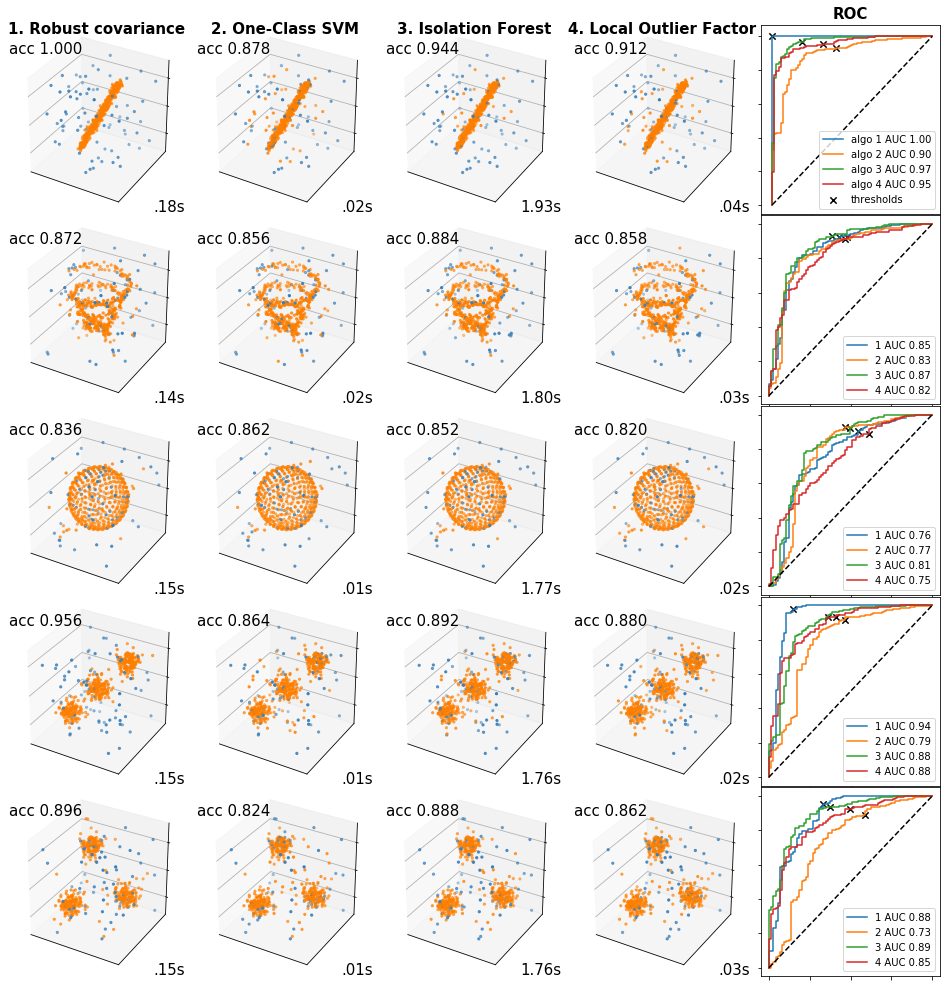

In [4]:
# Plot
plt.figure(figsize=((len(anomaly_algorithms) + 1) * 2.5 + 1, len(datasets3D) * 2.5 + 1))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.98, wspace=0.05, hspace=0.01
)
plot_num = 1
rng = np.random.RandomState(42)
for i_dataset3D, X in enumerate(datasets3D):
    # add uniform distribution outliers
    X = np.concatenate(
        [X, rng.uniform(low=-1.5, high=1.5, size=(n_outliers, 3))], axis=0
    )
    # add Gaussian dimensional noise, set the center at origin
    X_noise = make_blobs(
        n_samples=n_samples,
        centers=1,
        n_features=2,
        random_state=0,
        cluster_std=1,
        center_box=(0.0, 0.0),
    )[0]
    X = np.append(X, X_noise, axis=1)

    # list of AUC and ROC
    list_AUC = []
    list_fpr = []
    list_tpr = []
    list_thresh = []

    algo_index = 0
    for name, algorithm in anomaly_algorithms:
        t0 = time.time()
        algorithm.fit(X)

        # fit the data and tag outliers
        y_pred = algorithm.fit(X).predict(X)

        # outlier detection performance
        acc = accuracy_score(y_true, y_pred)
        probas_ = algorithm.fit(X).decision_function(X)
        AUC = roc_auc_score(y_true, probas_)
        fpr, tpr, thresholds = roc_curve(y_true, probas_)
        thresh_index = np.where(abs(thresholds) == min(abs(thresholds)))[0][0]

        # store the measurement for the plot
        list_AUC.append(AUC)
        list_fpr.append(fpr)
        list_tpr.append(tpr)
        list_thresh.append(thresh_index)

        t1 = time.time()

        # add data plot
        ax = plt.subplot(
            len(datasets3D), len(anomaly_algorithms) + 1, plot_num, projection="3d"
        )
        ax.axis("on")
        if i_dataset3D == 0:
            plt.title(
                str(algo_index + 1) + ". " + name, size=15, color="black", weight="bold"
            )  # use function's name for a title
        colors = np.array(["#377eb8", "#ff7f00"])
        # color plot ('blue' = outlier, 'orange'=inlier)
        ax.scatter3D(X[:, 0], X[:, 1], X[:, 2], s=5, color=colors[((y_pred + 1) // 2)])
        ax.text2D(
            0.01,
            0.85,
            ("acc %.3f" % acc).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="left",
        )
        ax.text2D(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        ax.set_xticks([])
        ax.set_yticks([])
        ax.zaxis.set_ticklabels([])
        algo_index += 1
        plot_num += 1
    # add ROC plot
    ax = plt.subplot(len(datasets3D), len(anomaly_algorithms) + 1, plot_num)
    if i_dataset3D == 0:
        plt.title("ROC", size=15, color="black", weight="bold")
        # use function's name for a title
    for algo_index in range(len(anomaly_algorithms)):
        # plot ROC and threshold point
        # many if and else is to clean the legend
        if i_dataset3D == 0:
            ax.plot(
                list_fpr[algo_index],
                list_tpr[algo_index],
                label="algo "
                + str(algo_index + 1)
                + (" AUC %.2f" % list_AUC[algo_index]).lstrip("0"),
            )
            if algo_index == 0:
                ax.scatter(
                    list_fpr[algo_index][list_thresh[algo_index]],
                    list_tpr[algo_index][list_thresh[algo_index]],
                    s=40,
                    edgecolor="yellow",
                    marker="x",
                    color="black",
                    label="thresholds",
                )
            else:
                ax.scatter(
                    list_fpr[algo_index][list_thresh[algo_index]],
                    list_tpr[algo_index][list_thresh[algo_index]],
                    s=40,
                    edgecolor="yellow",
                    marker="x",
                    color="black",
                )
        else:
            ax.plot(
                list_fpr[algo_index],
                list_tpr[algo_index],
                label=str(algo_index + 1)
                + (" AUC %.2f" % list_AUC[algo_index]).lstrip("0"),
            )
            ax.scatter(
                list_fpr[algo_index][list_thresh[algo_index]],
                list_tpr[algo_index][list_thresh[algo_index]],
                s=40,
                edgecolor="yellow",
                marker="x",
                color="black",
            )
    ax.plot(np.array([0, 1]), np.array([0, 1]), linestyle="--", color="black")
    # show the legend
    ax.legend()
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    plot_num += 1
print("d_noise = ", str(d_noise))
plt.show()

## Result and disscussion 
The figures show the outlier detection performance and visualization. Each row represent different datasets. The first four columns compare each algorithm the computation time (``.__ s``) and outlier prediction accuracy (``acc``). The number and name of each outlier detection algorithm are on the top of the column. The last column plots all four algorithms in the ROC curve compare AUC score. The number label on AUC score matches the number in front of the algorithm names. The ``x`` in the ROC curves indicate the thresholds where algorithms start to classify data as outliers.

From the plots, ``sklearn.covariance.EllipticEnvelope`` shows best result in high dimensional noise ``d_noise = 10``. However, since robust covariance create a ellptical envelope for inliers, we need more test on an inlier data that is not in a elliptical shape.